# Constant thermodynamic speed schedules for simulated annealing

This notebook examines simulated annealing schedules based on thermodynamic speed as defined in `[1,2,3]`.

## Introduction

We wish to find an optimal temperature schedule for any total budget.
Many authors have argued that optimal schedules should progress with constant thermodynamic speed. Let us define two approximations of thermodynamic speed.
Let `E` be energy, `T` be temperature, `t` be the timestep, and define _heat capacity_ $C_V$ via
\begin{align*}
    \sigma_E &= \sqrt{\langle E^2\rangle - \langle E\rangle^2}
             = \operatorname{stddev}(E) \\
    C_V &= \frac {\sigma_E^2}{T^2}
\end{align*}
As defined in `[2 pp. 33 eqn. 5.29-5-31]` and `[3 pp. 2 eqn. 5]`, the moments of `E` are evaluated over an ensemble at the current temperature `T`.

`[1]` define two schedules of constant thermodynamic speed. The first "TDS1" assumes slow annealing `[1 eqn. 6]`:
$$
    \frac{d\log T}{dt} = \frac 1 T \frac {dT}{dt} = \frac {-v_s} {\epsilon \sqrt{C_v}}
$$
where $\epsilon$ is the relaxation time (related to but not identical to [mixing time](https://proceedings.neurips.cc/paper/2015/file/7ce3284b743aefde80ffd9aec500e085-Paper.pdf)) and $v_s$ is a fixed constant. The second schedule "TDS2" is accurate at faster annealing rates `[1 eqn. 7-8]`:
\begin{align*}
    \frac{d\log T}{dt} &= \frac {-v_s} {\epsilon\sqrt{C}\sqrt{1+\Theta(t)\epsilon \frac{d\log T}{dt}}} \\
    \Theta(t) &= 1 + \frac {T}{2C_v} \frac {\partial C}{\partial T}
\end{align*}
For simplicity let us focus on the simpler TDS1. Let us also assume that relaxation time $\epsilon(t)$ is either constant, or can be estimated by say the reciprocal of MH acceptance rate or some other heuristic (it need only be estimated up to a constant factor).

To assess nearly expenential schedules $\frac{d\log T}{dt} =:k(t)$ for slowly varying $k(-)$, we can simply plot a number proportional to thermodynamic speed:
$$
  k(t) = \frac{d\log T}{dt}
       = \frac {-v_s} {\epsilon \sqrt{C_v}}
       \propto \frac 1 {\epsilon \sqrt{C_v}}
       \approx \frac 1 {\sqrt{C_v}}
       = \frac 1 {\operatorname{stddev}\left(\frac E T\right)}
$$
or simply estimating the desired slowdown:
$$
\frac 1 {k(t)} \propto \operatorname{stddev}\left(\frac E T\right)
$$
which is trivial to estimate over an ensemble of samples.

### References

1. [Nourani and Andresen (1994)](https://iopscience.iop.org/article/10.1088/0305-4470/31/41/011)
   "A comparison of simulated annealing cooling strategies"
2. [Salamon, Sibani, and Frost (2002)](https://doi.org/10.1137/1.9780898718300)
   "Facts, Conjectures, and Improvements for Simulated Annealing"
3. [Karabin and Stuart (2020)](https://doi.org/10.1063/5.0018725)
   "Simulated Annealing with Adaptive Cooling Rates"

In [4]:

import math
import torch
import torch.distributions as dist
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from opt_einsum import contract as einsum
from tqdm.auto import tqdm

matplotlib.rcParams.update({'figure.facecolor': "white"})
matplotlib.rcParams.update({'figure.dpi': 200})

The model and proposal distribution follow [thermodynamic-integration.ipynb](https://github.com/fritzo/notebooks/blob/master/thermodynamic-integration.ipynb).

In [5]:
class Potts:
    def __init__(self, p, k):
        self.v = torch.randn(p, k)
        self.e = torch.randn(p, p, k, k) / 2
    def __call__(self, x):
        if x.dtype.is_floating_point:
            return einsum("...vi,vi", x, self.v) + einsum("...ui,...vj,uvij", x, x, self.e)

In [6]:
def logp_and_nbhd(f, x):
    x.requires_grad_()
    logp = f(x)
    assert logp.shape == x.shape[:-2]
    nbhd = torch.autograd.grad(logp.sum(), [x])[0].detach()
    x.detach_()
    logp.detach_()
    nbhd -= (nbhd * x).sum(-1, True)
    nbhd /= 2
    return logp, nbhd

def make_proposal(x, logq):
    logq = logq.clamp(max=20)
    logq += x * logq.exp().sum(-1, True).max(-2, True).values.sub(1).clamp(min=1).log()
    logq -= logq.logsumexp(-1, True)
    return logq
    
def anneal(
    f: callable, p: int, k: int, num_samples: int, schedule
) -> torch.Tensor:
    trace = defaultdict(list)
    x0 = dist.OneHotCategorical(torch.ones(p, k)).sample([num_samples])
    logp0, nbhd0 = logp_and_nbhd(f, x0)
    best = logp0.clone()
    for temperature in tqdm(schedule):
        logq0 = make_proposal(x0, nbhd0 / temperature)
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = (x0 != x1).any(-1).float().sum(-1)
        if (x0 == x1).all():
            acceptance_rate = 1
        else:
            logp1, nbhd1 = logp_and_nbhd(f, x1)
            logq1 = make_proposal(x1, nbhd1 / temperature)
            logq10 = einsum("bpk,bpk->b", logq1, x0)
            logq01 = einsum("bpk,bpk->b", logq0, x1)
            ratio = ((logp1 - logp0) / temperature + logq10 - logq01).exp()
            accept = ratio > torch.rand(ratio.shape)
            acceptance_rate = accept.float().mean().item()
            if accept.all():
                x0, logp0, nbhd0 = x1, logp1, nbhd1
            elif accept.any():
                x0[accept] = x1[accept]
                logp0[accept] = logp1[accept]
                nbhd0[accept] = nbhd1[accept]
            best = torch.maximum(best, logp0)
        z = logp0 / temperature
        trace["temperature"].append(temperature)
        trace["logp_best"].append(best.max().item())
        trace["logp_worst"].append(best.min().item())
        trace["speed"].append(distance[accept].sum().item() / p)
        trace["z_mean"].append(z.mean().item())
        trace["z_std"].append(z.std().item())
        trace["accept"].append(acceptance_rate)
        
    return dict(trace)

In [7]:
def get_trace(p, k, num_steps=1000, num_samples=1000, t_min=0.1, t_max=10.0):
    print(f"Simulating {k}^{p} states for {num_steps} steps")
    torch.manual_seed(20220723)
    f = Potts(p, k)
    schedule = torch.linspace(math.log(t_max), math.log(t_min), num_steps).exp().tolist()
    trace = anneal(f, p, k, num_samples, schedule)
    return trace

def plot_trace(trace):
    trace = dict(trace)
    z_mean = torch.tensor(trace["z_mean"])
    z_std = torch.tensor(trace["z_std"])
    temperature = torch.tensor(trace["temperature"])
    trace["E_mean"] = z_mean * temperature
    trace["E_std"] = z_std * temperature
    x = torch.arange(len(trace["temperature"])).float()
    plt.figure(figsize=(6, 5))
    for name, series in sorted(trace.items()):
        if not name.startswith("logp_"):
            plt.plot(series, label=name)
    plt.fill_between(x, trace["logp_worst"], trace["logp_best"], color="red", alpha=0.2,
                     label="optima")
    plt.axhline(1.0, color="black", ls="--", lw=1, alpha=0.5)
    plt.yscale("log")
    plt.xlim(x[0], x[-1] + 1)
    plt.xlabel("mcmc step")
    plt.legend(loc="best", fontsize=8)
    lb = trace['logp_worst'][-1]
    ub = trace['logp_best'][-1]
    plt.title(f"Final objective in [{lb:0.4g}, {ub:0.4g}]")
    plt.tight_layout()

In [8]:
trace = get_trace(50, 20)

Simulating 20^50 states for 1000 steps


  0%|          | 0/1000 [00:00<?, ?it/s]

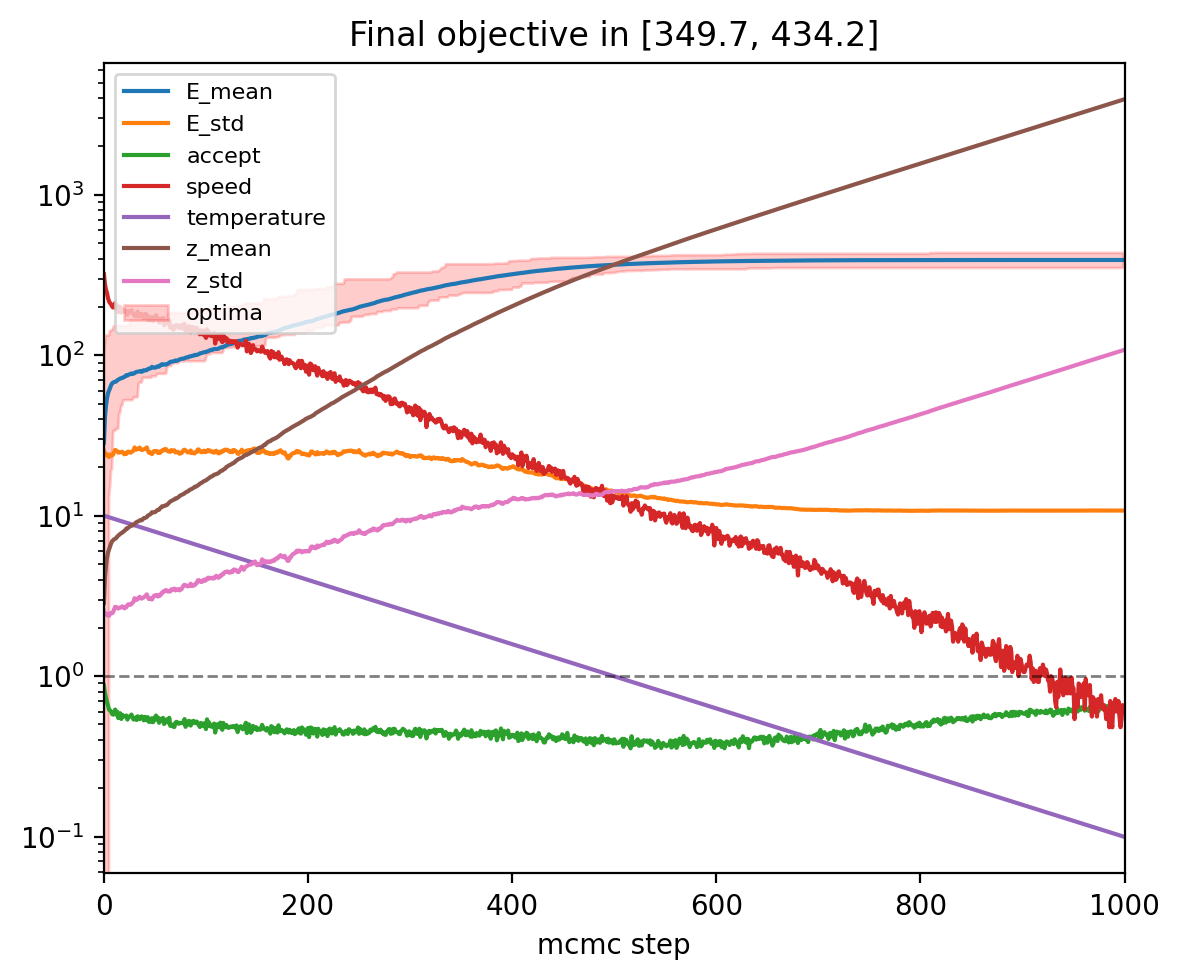

In [9]:
plot_trace(trace)

Now `z_std` $= \sigma_E/T = \sqrt{C_v}$ is the square root of the heat capacity, and is proportional to our desired exponential slowdown.  Notice `E_std = z_std * temperature` is nearly constant and slowly decreasing. It looks like we'll want a schedule that's slower than exponential (assuming mixing $\epsilon$ time only slows down with decreased temperature). At the same time, our schedule is given a fixed budget, and it may be expensive to dynamically adapt.

What if we simply decelarate on a fixed budget, say by a quadratic function?

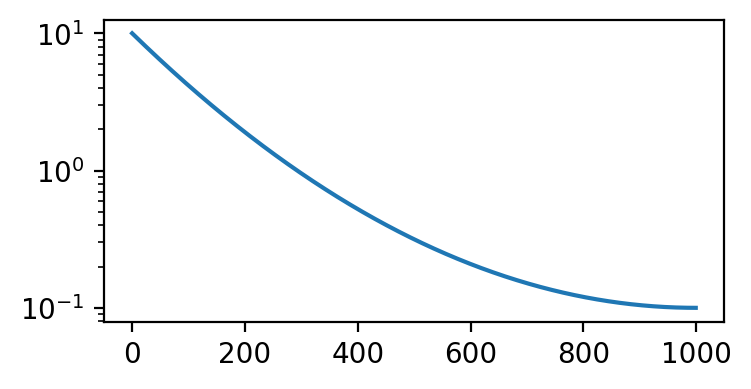

In [10]:
def _():
    t_min = 0.1
    t_max = 10.0
    num_steps = 1000
    t = torch.linspace(1.0, 0.0, num_steps).square().sub(1).neg()
    schedule = t.mul(math.log(t_min / t_max)).add(math.log(t_max)).exp().tolist()
    plt.figure(figsize=(4,2))
    plt.plot(schedule)
    plt.yscale("log")
    
_()

In [11]:
def get_trace_2(p, k, num_steps=1000, num_samples=1000, t_min=0.1, t_max=10.0):
    print(f"Simulating {k}^{p} states")
    torch.manual_seed(20220723)
    f = Potts(p, k)
    t = torch.linspace(1.0, 0.0, num_steps).square().sub(1).neg()
    schedule = t.mul(math.log(t_min / t_max)).add(math.log(t_max)).exp().tolist()
    trace = anneal(f, p, k, num_samples, schedule)
    return trace

In [119]:
trace2 = get_trace_2(50, 20)

Simulating 20^50 states


  0%|          | 0/1000 [00:00<?, ?it/s]

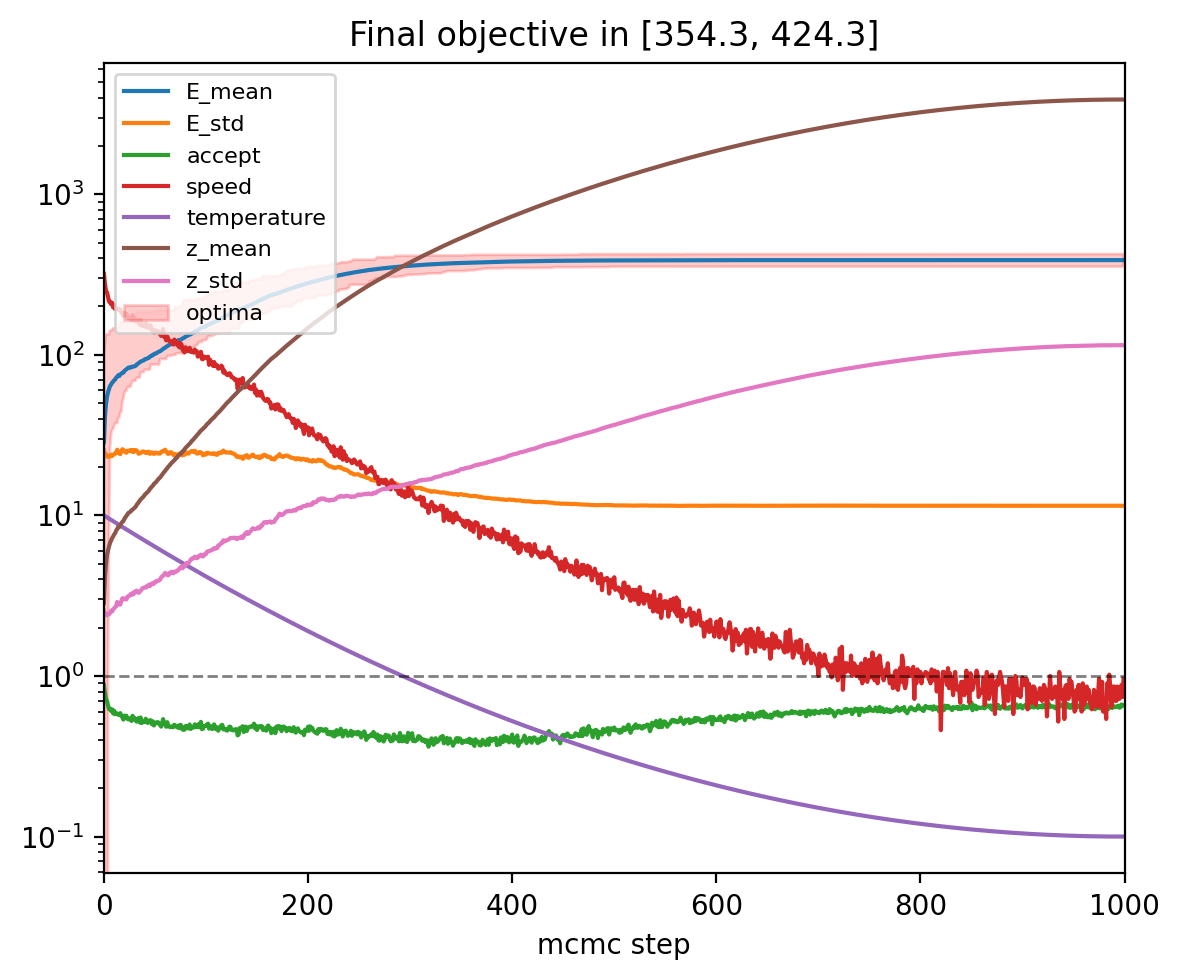

In [120]:
plot_trace(trace2)

It looks like this doesn't help :-(

## How many steps are needed for optimization?

In [29]:
if "traces" not in locals():
    traces = {}

In [70]:
for num_steps in [2**n for n in range(0, 15)]:
    if num_steps not in traces:
        traces[num_steps] = get_trace(100, 20, num_steps, 100)

Simulating 20^100 states for 16384 steps


  0%|          | 0/16384 [00:00<?, ?it/s]

In [71]:
def plot_traces(traces: dict):
    xs = sorted(traces)
    lbs = [traces[x]["logp_worst"][-1] for x in xs]
    ubs = [traces[x]["logp_best"][-1] for x in xs]
    mean = torch.tensor([traces[x]["z_mean"][-1]  for x in xs]) / 10
    std = torch.tensor([traces[x]["z_std"][-1] for x in xs]) / 10
    for trace in traces.values():
        ts = torch.arange(1, 1 + len(trace["z_mean"]))
        plt.plot(ts, torch.tensor(trace["z_mean"]) / 10, "k-", lw=1, alpha=0.1)
    plt.fill_between(xs, lbs, ubs, color="brown", alpha=0.2, label="min,max")
    plt.fill_between(xs, mean - std, mean + std, color="blue", alpha=0.2, label="1 stddev")
    plt.plot(xs, mean, "k--", lw=1, label="mean")
    plt.legend(loc="best")
    plt.xlim(min(traces), max(traces))
    plt.xlabel("schedule length")
    plt.ylabel("objective function range")
    plt.xscale("log")

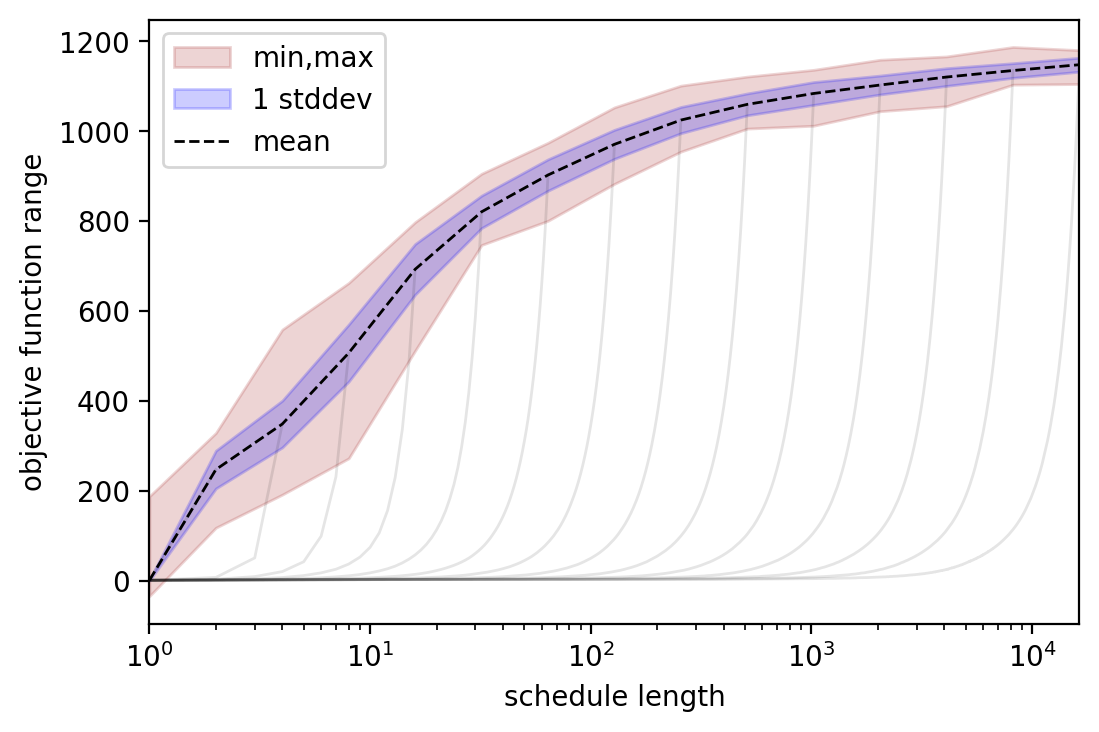

In [72]:
plot_traces(traces)

## Comparison to Gibbs sampling

In [73]:
def anneal_gibbs(
    f: callable, p: int, k: int, num_samples: int, schedule
) -> torch.Tensor:
    trace = defaultdict(list)
    B = num_samples
    b = torch.arange(B)
    i = torch.empty(B, dtype=torch.long)
    x0 = dist.OneHotCategorical(torch.ones(p, k)).sample([B])
    best = f(x0)
    for temperature in tqdm(schedule):
        x1 = x0.unsqueeze(-2).expand(B, p, k, k).clone()
        x1[b, i.random_(p), :] = torch.eye(k)
        x1 = x1.transpose(1, 2)
        assert x1.shape == (B, k, p, k)
        f1 = f(x1)
        logits = f1 / temperature
        assert logits.shape == (B, k)
        choice = dist.Categorical(logits=logits).sample()
        assert choice.shape == (B,)
        x0 = x1[b, choice]
        f0 = f1[b, choice]
        z = f0 / temperature
        best = torch.maximum(best, f0)
        trace["temperature"].append(temperature)
        trace["logp_best"].append(best.max().item())
        trace["logp_worst"].append(best.min().item())
        trace["z_mean"].append(z.mean().item())
        trace["z_std"].append(z.std().item())
    return dict(trace)

In [74]:
def get_trace_gibbs(p, k, num_steps=1000, num_samples=1000, t_min=0.1, t_max=10.0):
    print(f"Simulating {k}^{p} states for {num_steps} steps")
    torch.manual_seed(20220723)
    f = Potts(p, k)
    schedule = torch.linspace(math.log(t_max), math.log(t_min), num_steps).exp().tolist()
    trace = anneal_gibbs(f, p, k, num_samples, schedule)
    return trace

In [75]:
if "traces_gibbs" not in locals():
    traces_gibbs = {}

In [76]:
for num_steps in [2**n for n in range(0, 12)]:
    if num_steps not in traces_gibbs:
        traces_gibbs[num_steps] = get_trace_gibbs(100, 20, num_steps, 100)

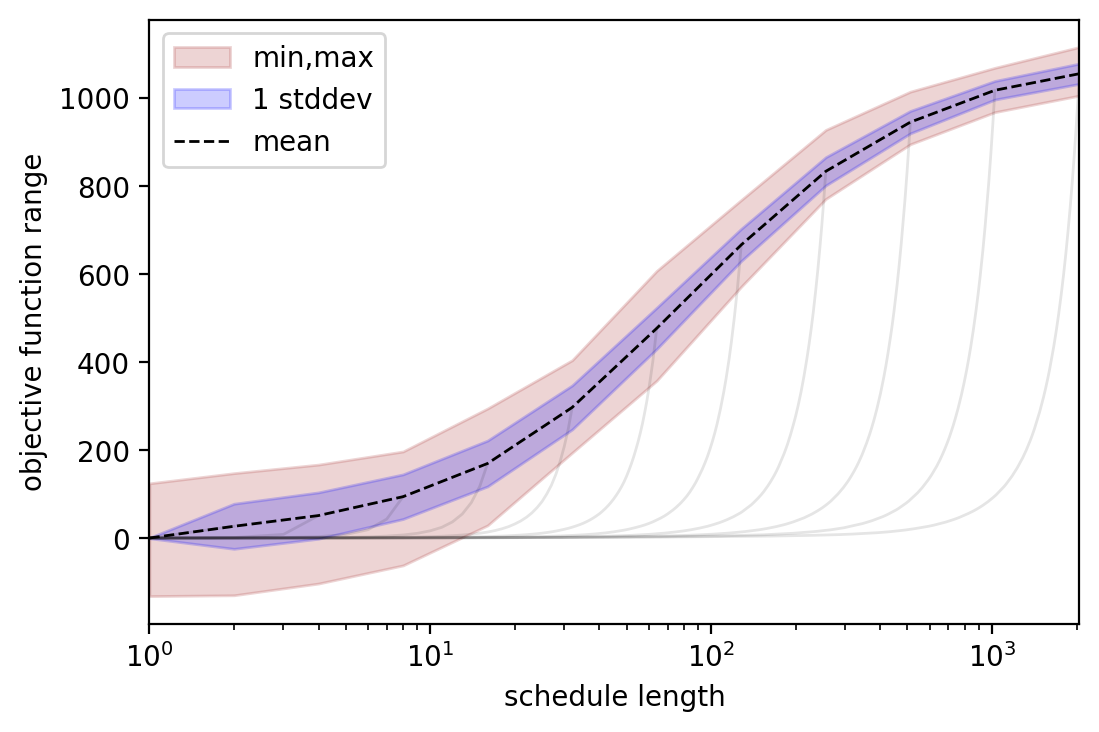

In [77]:
plot_traces(traces_gibbs)

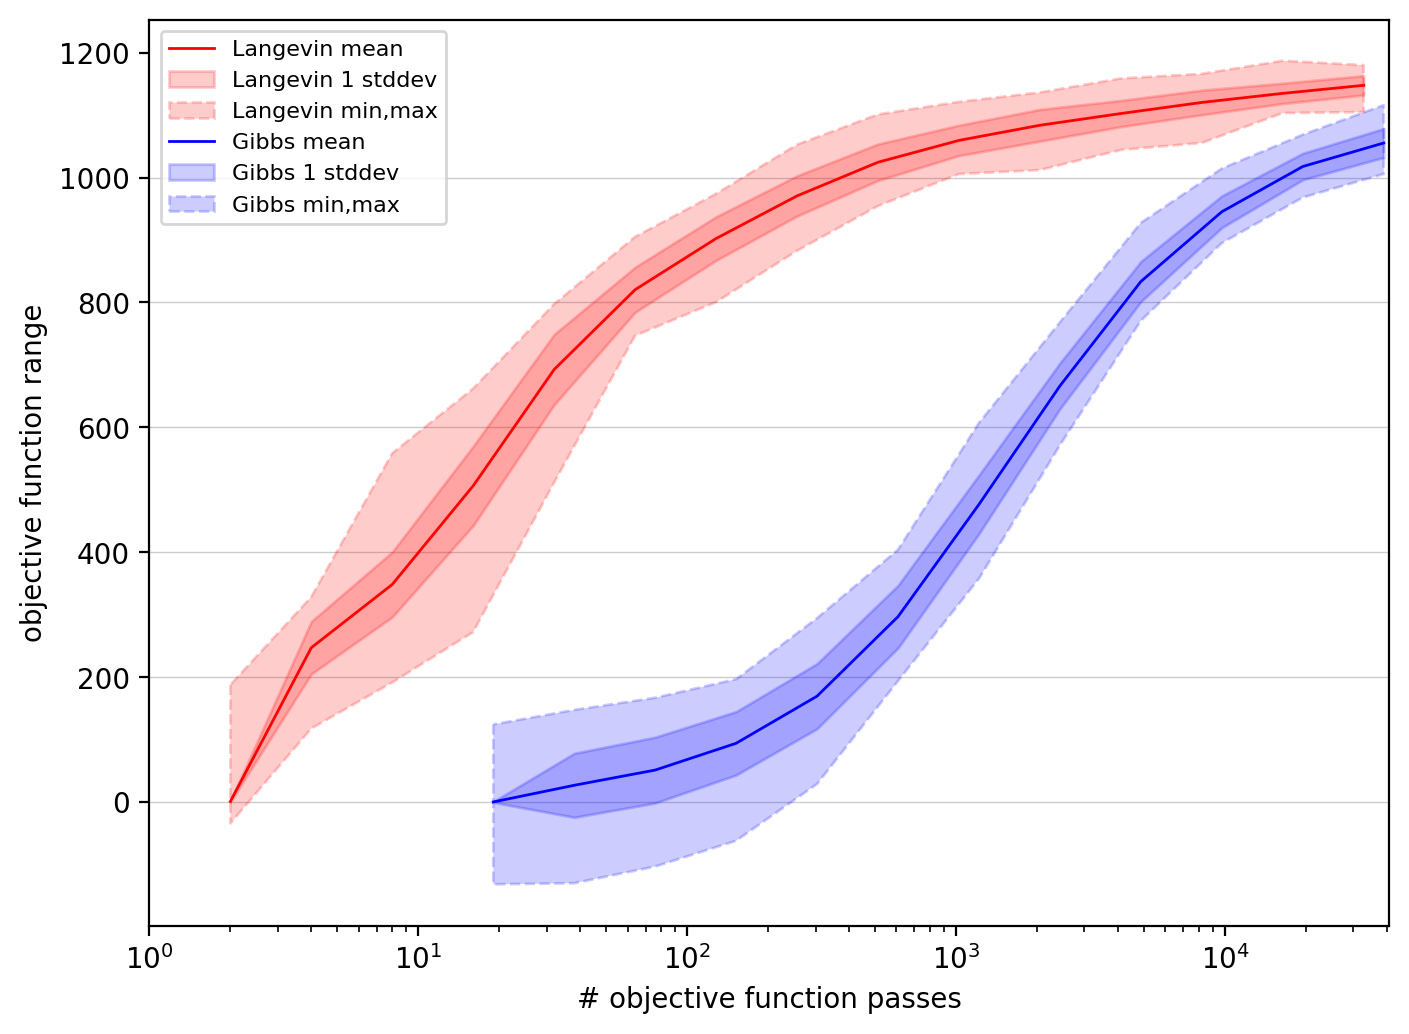

In [83]:
def plot_comparison(traces_langevin: dict, traces_gibbs: dict):
    plt.figure(figsize=(8,6))
    for name, color, traces, cost in [
        ("Langevin", "red", traces_langevin, 2),
        ("Gibbs", "blue", traces_gibbs, 19),
    ]:
        xs = sorted(traces)
        cost = torch.tensor(xs) * cost
        lbs = [traces[x]["logp_worst"][-1] for x in xs]
        ubs = [traces[x]["logp_best"][-1] for x in xs]
        mean = torch.tensor([traces[x]["z_mean"][-1]  for x in xs]) / 10
        std = torch.tensor([traces[x]["z_std"][-1] for x in xs]) / 10
        plt.plot(cost, mean, color=color, ls="-", lw=1, label=f"{name} mean")
        plt.fill_between(cost, mean - std, mean + std, color=color, alpha=0.2,
                         label=f"{name} 1 stddev")
        plt.fill_between(cost, lbs, ubs, color=color, alpha=0.2, ls="--",
                         label=f"{name} min,max")
    for y in [0, 200, 400, 600, 800, 1000]:
        plt.axhline(y, color="black", lw=0.5, alpha=0.2, zorder=-1)
    plt.legend(loc="best", fontsize=8)
    plt.xlim(1, None)
    plt.xlabel("# objective function passes")
    plt.ylabel("objective function range")
    plt.xscale("log")
    
plot_comparison(traces, traces_gibbs)